In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import local_acq, mixture_acq, generate, likelihood

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward


In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

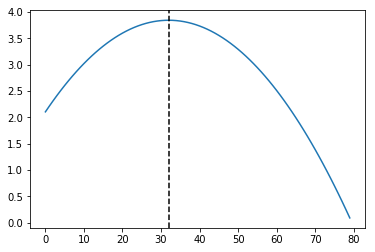

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

In [5]:
params = {'steepness':np.array([.5]),
              'x_midpoint':np.array([10]),
              'yscale':np.array([1]),
              'phase_ucb_temperature':np.array([.001]),
              'learning_rate':np.array([350]),
              'stay_penalty':np.array([-10]),
              'local_temperature':np.array([.001]),
              'mes_temperature':np.array([.01]),
              'mixture':(np.ones(3) / 3.)[:,None]}

In [6]:
data = generate(mixture_acq, params, neg_quad_kern, neg_quad, 20, 10, 1, [1.])[0]

In [7]:
actions = data[j][i][:,:,5].argmax(axis=2)
axes[j][i].plot(actions[:5].T);
        axes[j][i].axhline(y=fmax, ls='--', c='black');
        if j == 0:
            axes[j][i].set_title(titles[i])

NameError: name 'temp_params' is not defined